In [1]:
from netCDF4 import Dataset, MFDataset
import pyfesom2 as pf
import numpy as np
#from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
import argparse, os, sys
import netCDF4 as nc 

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

%matplotlib inline

def read_data(finname, var, transpose=True):
    with Dataset(finname,'r') as fin:
        data = fin.variables[var]
        ndim = len(data.dimensions)

        # Check if time dimension is there.
        if "time" in data.dimensions:
            print("data dimensions:", data.dimensions, data.shape)
        else:
            raise ValueError('No time dimension!')

        if transpose:
            if ndim == 3:
                if (
                    ("nz1" in data.dimensions)
                    and ("nod2" in data.dimensions)            
                ):
                    if (data.dimensions != ("time", "nod2", "nz1")):
                        #data = data.transpose("time", "nod2", "nz1")
                        data = np.transpose(data, axes=(0,2,1))

                elif (
                    ("nz" in data.dimensions)
                    and ("nod2" in data.dimensions)                 
                ):
                    if (data.dimensions != ("time", "nod2", "nz")):
                        #data = data.transpose("time", "nod2", "nz")
                        data = np.transpose(data, axes=(0,2,1))

                elif (
                    ("nz1" in data.dimensions)
                    and ("elem" in data.dimensions)                  
                ):
                    if (data.dimensions != ("time", "elem", "nz1")):
                        #data = data.transpose("time", "elem", "nz1")
                        data = np.transpose(data, axes=(0,2,1))
                elif (
                    ("nz" in data.dimensions)
                    and ("elem" in data.dimensions)                  
                ):
                    if  (data.dimensions != ("time", "elem", "nz")):
                        #data = data.transpose("time", "elem", "nz")
                        data = np.transpose(data, axes=(0,2,1))
                else:
                    raise ValueError('dimension is unknown!')

        datanew = data[:]

    return datanew, ndim





def main(meshpath, finname,
         foutname = 'data_regular.nc',
         depth_range=None,
         varnames = ['temp', 'salt'],
         nlon = 1440,
         nlat = 720,
         abg = [0.,0.,0.]):

    mesh = pf.load_mesh(meshpath,abg=abg, usepickle=False)


    # get the depth information
    if depth_range is None:
        depths = mesh.zlev[:-1]
    else:
        idx = (np.abs(mesh.zlev) >= depth_range[0]) & (np.abs(mesh.zlev) <= depth_range[1])
        depths = mesh.zlev[idx]

    nlev = len(depths)

    # the new regular grids:
    lon = np.linspace(-180, 180, nlon)
    lat = np.linspace(-90, 90, nlat)
    lons, lats = np.meshgrid(lon,lat)


    # read the time dim:
    fin = Dataset(finname,'r')
    timein = fin.variables['time']
    ntime = len(timein)

    # write data
    with Dataset(foutname, 'w') as fout:
        fout.createDimension('lat', nlat)
        latout = fout.createVariable('lat',np.float32, ('lat',))
        latout.units = 'degree_north'
        latout.standard_name = 'latitude'
        latout[:] = lat

        fout.createDimension('lon', nlon)
        lonout = fout.createVariable('lon',np.float32,('lon',))
        lonout.units = 'degree_east'
        lonout.standard_name = 'longitude'
        lonout[:] = lon

        fout.createDimension('time', None)
        timeout = fout.createVariable('time',np.float32,('time',))
        timeout.setncatts(timein.__dict__)
        timeout[:] = timein[:]

        fout.createDimension('level', None)
        levout = fout.createVariable('level',np.float32,('level',))
        levout.units = 'm'


        fout.description =  'interpolated fesom2.0 data'

        for thevar in varnames:
            print(">>>>>>>>>> processing >>> ",thevar)
            # read data
            data, ndim = read_data(finname, thevar)
            print(data.shape)

            varout = fout.createVariable(thevar,np.float32,('time','level','lat','lon'))

            for it in range(0,ntime):
                print("> time step ", it)
                if ndim == 3:
                    levout[:] = depths
                    for iz in range(0,nlev):
                        ilev = pf.ind_for_depth(depths[iz], mesh)
                        print("> level:", depths[iz])
                        level_data = data[it, :, ilev]
                        level_data[level_data==0] = np.nan
                        #idist_fast = pf.fesom2regular(level_data, mesh, lons, lats, how='idist', k=20)
                        idist_fast = pf.fesom2regular(level_data, mesh, lons, lats )
                        varout[it,iz,:,:] = idist_fast

                elif ndim == 2:
                    levout[:] = 0. # meter
                    print("> surface")
                    level_data = data[it, :]
                    idist_fast = pf.fesom2regular(level_data, mesh, lons, lats )
                    varout[it,0,:,:] = idist_fast



    # close input data
    fin.close()
    return

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196.
 197. 

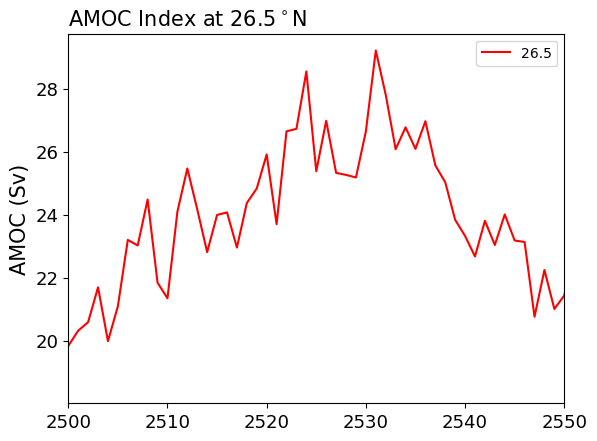

In [2]:
fname = '/home/a/a270075/ba0989/awiesm_pism/experiments-MOW/32k-MOW0.3/viz/fesom/amoc_timeseries.nc'
# plot
with nc.Dataset(fname, 'r') as ff:
    amoc = ff.variables['AMOC_26.5'][:]
    years = ff.variables['time'][:]

print(years)

fig = plt.figure()
ax = fig.add_subplot(1, 1,1)

ax.plot(years+2500-1, amoc, color='red', ls='-', label='26.5') 
ax.set_xlim(2500, 2550)
# ax.set_ylim(0, 30)
ax.set_ylabel('AMOC (Sv)', fontsize=15)
ax.set_title('AMOC Index at 26.5$^\circ$N', fontsize=15,  loc='left')
ax.tick_params(labelsize=13)

ax.legend()

# plt.savefig(foutname.replace('.nc','.png'))
# plt.show(block=False)
# plt.pause(3)
# plt.close()

In [3]:
# %%bash 
# datapath=/home/a/a270075/ba0989/awiesm_pism/experiments-MOW/32k-MOW0.3/outdata/fesom/
# cdo cat  ${datapath}/temp.fesom.25??01.01.nc  tmp.nc 
# cdo -timmean -seldate,2526-01-01,2531-12-31  tmp.nc  temp_32k-MOW0.3_2526-2531.nc  
# cdo -timmean -seldate,2501-01-01,2506-12-31  tmp.nc  temp_32k-MOW0.3_2501-2506.nc  
# rm tmp.nc 

# cdo cat  ${datapath}/salt.fesom.25??01.01.nc  tmp.nc 
# cdo -timmean -seldate,2526-01-01,2531-12-31  tmp.nc  salt_32k-MOW0.3_2526-2531.nc  
# cdo -timmean -seldate,2501-01-01,2506-12-31  tmp.nc  salt_32k-MOW0.3_2501-2506.nc  
# rm tmp.nc 

# cdo merge temp_32k-MOW0.3_2526-2531.nc   salt_32k-MOW0.3_2526-2531.nc   32k-MOW0.3_2526-2531.nc
# cdo merge temp_32k-MOW0.3_2501-2506.nc   salt_32k-MOW0.3_2501-2506.nc   32k-MOW0.3_2501-2506.nc

In [4]:
# #### defination:

# meshpath = '/home/a/a270075/ba0989/pool/meshes/38k/mesh_GLAC38_PM38/'
# varnames = ['temp', 'salt' ]


# main(meshpath, '32k-MOW0.3_2526-2531.nc', foutname ='32k-MOW0.3_2526-2531_reg.nc', depth_range=None,
#          varnames = varnames,nlon = 1440,nlat = 720,abg=[0.,0.,0.],)
# main(meshpath, '32k-MOW0.3_2501-2506.nc', foutname ='32k-MOW0.3_2501-2506_reg.nc', depth_range=None,
#          varnames = varnames,nlon = 1440,nlat = 720,abg=[0.,0.,0.],)

In [9]:
# !cdo sub  32k-MOW0.3_2526-2531_reg.nc   32k-MOW0.3_2501-2506_reg.nc   diff_32k-MOW0.3.nc 

In [6]:
import xarray as xr 


In [7]:
ds1 = xr.open_dataset('32k-MOW0.3_2526-2531_reg.nc')
temp1 = ds1['temp']
salt1 = ds1['salt']

ds2 = xr.open_dataset('diff_32k-MOW0.3.nc') 
tempdiff = ds2['temp']
saltdiff = ds2['salt']



/home/a/a270075/.local/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/a/a270075/.local/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/home/a/a270075/.local/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/a/a270075/.local/lib/python3.10/site-packages/xarray/core/indexing.py:560: Seriali

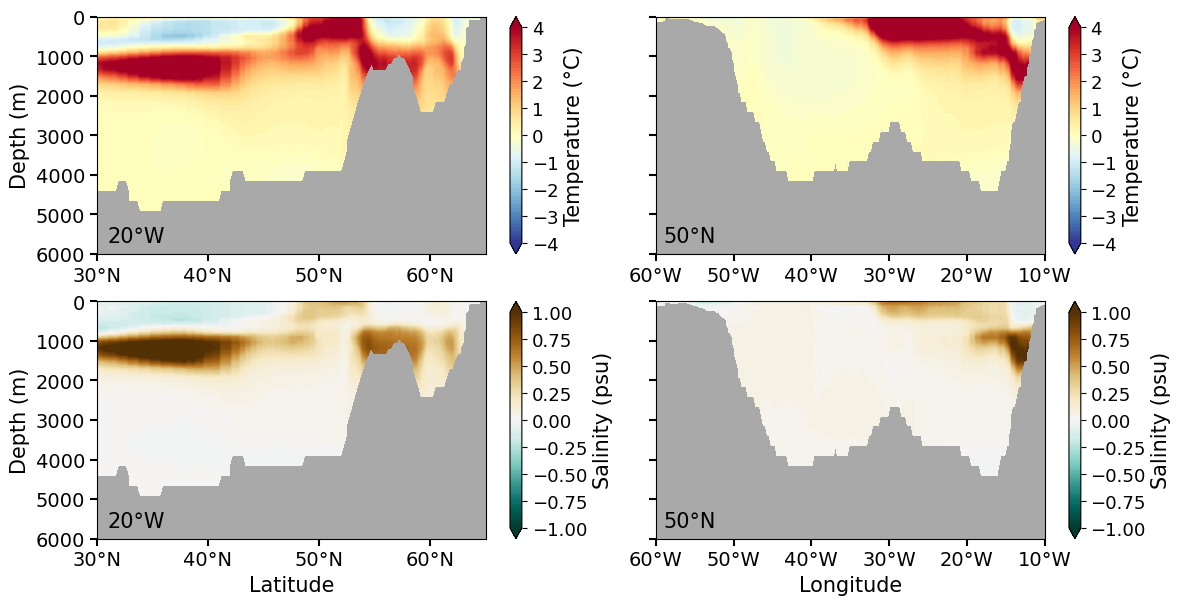

In [8]:
import cartopy.mpl.ticker as cticker
lon_formatter = cticker.LongitudeFormatter()  
lat_formatter = cticker.LatitudeFormatter() 


fig = plt.figure(figsize=(11, 6))
gs = fig.add_gridspec(nrows=2,ncols=2,bottom=0.08,top=0.95,left=0.04,right=0.99,hspace=0.2,wspace=0.15)


###################### plot 1 
section = tempdiff.sel(lon=-20, method='nearest')
section = section.isel(time=0)
section = section.where(temp1.sel(lon=-20, method='nearest').isel(time=0)<9.9e36)

minval = -4
maxval = 4
nbreaks = 81
breaks = np.linspace(minval,maxval,nbreaks)
color = plt.cm.RdYlBu_r

axs = fig.add_subplot(gs[0,0])                     
lon_section = section.transpose('level', 'lat')  
cs = axs.contourf(section['lat'], -section['level'], section,breaks,vmin=minval,vmax=maxval,extend='both', cmap=color)
plt.gca().invert_yaxis()

axs.set_xlim(30,65)
axs.set_ylim(6000,0)
axs.set_facecolor('darkgrey') 
axs.tick_params(axis='x', which='major', direction='out',size=5, width=1.5, labelsize=14)
axs.tick_params(axis='y', which='major', direction='out',size=5, width=1.5, labelsize=14)
axs.xaxis.set_major_formatter(lat_formatter)
# axs.set_xlabel('Latitude (°)', fontsize=15)
axs.set_ylabel('Depth (m)', fontsize=15)

axs.text(31,5700, '20°W', fontsize=15)

cbar = plt.colorbar(cs, label='Temperature (°C)')
cbar.set_label(label='Temperature (°C)', size=15)
cbar.ax.tick_params(labelsize=13)
cbar.set_ticks(np.arange(minval,maxval+0.01,1))

####################### plot 2 
sectionsalt = saltdiff.sel(lon=-20, method='nearest')
sectionsalt = sectionsalt.isel(time=0)
sectionsalt = sectionsalt.where(temp1.sel(lon=-20, method='nearest').isel(time=0)<9.9e36)

minval = -1
maxval = 1
nbreaks = 81
breaks = np.linspace(minval,maxval,nbreaks)
color = plt.cm.BrBG_r

axs = fig.add_subplot(gs[1,0])                     
lon_section = section.transpose('level', 'lat')  
cs = axs.contourf(section['lat'], -section['level'], sectionsalt,breaks,vmin=minval,vmax=maxval,extend='both', cmap=color)
plt.gca().invert_yaxis()

axs.set_xlim(30,65)
axs.set_ylim(6000,0)
axs.set_facecolor('darkgrey') 
axs.tick_params(axis='x', which='major', direction='out',size=5, width=1.5, labelsize=14)
axs.tick_params(axis='y', which='major', direction='out',size=5, width=1.5, labelsize=14)
axs.xaxis.set_major_formatter(lat_formatter)
axs.set_xlabel('Latitude', fontsize=15)
axs.set_ylabel('Depth (m)', fontsize=15)

axs.text(31,5700, '20°W', fontsize=15)

cbar = plt.colorbar(cs, label='Salinity (psu)')
cbar.set_label(label='Salinity (psu)', size=15)
cbar.ax.tick_params(labelsize=13)
cbar.set_ticks(np.arange(minval,maxval+0.01,0.25))


####################### plot 3 
section = tempdiff.sel(lat=50, method='nearest')
section = section.isel(time=0)
section = section.where(temp1.sel(lat=50, method='nearest').isel(time=0)<9.9e36)

minval = -4
maxval = 4
nbreaks = 81
breaks = np.linspace(minval,maxval,nbreaks)
color = plt.cm.RdYlBu_r

axs = fig.add_subplot(gs[0,1])                     
# lon_section = section.transpose('level', 'lon')  
cs = axs.contourf(section['lon'], -section['level'], section,breaks,vmin=minval,vmax=maxval,extend='both', cmap=color)
plt.gca().invert_yaxis()

axs.set_xlim(-60,-10)
# axs.set_ylim(6000,0)

axs.set_facecolor('darkgrey') 
axs.tick_params(axis='x', which='major', direction='out',size=5, width=1.5, labelsize=14)
axs.tick_params(axis='y', which='major', direction='out',size=5, width=1.5, labelsize=14, labelleft=False)
axs.xaxis.set_major_formatter(lon_formatter)
# axs.set_xlabel('Latitude (°)', fontsize=15)
# axs.set_ylabel('Depth (m)', fontsize=15)

axs.text(-59,5700, '50°N', fontsize=15)


cbar = plt.colorbar(cs, label='Temperature (°C)')
cbar.set_label(label='Temperature (°C)', size=15)
cbar.ax.tick_params(labelsize=13)
cbar.set_ticks(np.arange(minval,maxval+0.01,1))


####################### plot 4 
section = saltdiff.sel(lat=50, method='nearest')
section = section.isel(time=0)
section = section.where(temp1.sel(lat=50, method='nearest').isel(time=0)<9.9e36)

minval = -1
maxval = 1
nbreaks = 81
breaks = np.linspace(minval,maxval,nbreaks)
color = plt.cm.BrBG_r

axs = fig.add_subplot(gs[1,1])                     
# lon_section = section.transpose('level', 'lon')  
cs = axs.contourf(section['lon'], -section['level'], section,breaks,vmin=minval,vmax=maxval,extend='both', cmap=color)
plt.gca().invert_yaxis()

axs.set_xlim(-60,-10)
# axs.set_ylim(6000,0)
axs.set_facecolor('darkgrey') 
axs.tick_params(axis='x', which='major', direction='out',size=5, width=1.5, labelsize=14)
axs.tick_params(axis='y', which='major', direction='out',size=5, width=1.5, labelsize=14, labelleft=False)
axs.xaxis.set_major_formatter(lon_formatter)
axs.set_xlabel('Longitude', fontsize=15)
# axs.set_ylabel('Depth (m)', fontsize=15)

axs.text(-59,5700, '50°N', fontsize=15)

cbar = plt.colorbar(cs, label='Salinity (psu)')
cbar.set_label(label='Salinity (psu)', size=15)
cbar.ax.tick_params(labelsize=13)
cbar.set_ticks(np.arange(minval,maxval+0.01,0.25))

plt.savefig('profile_32k-MOW0.3.png',bbox_inches='tight',)
plt.show()
# plt.close()